## Analysis of the largest cluster

In [1]:
import sys, os
add_libs = [
"/global/u1/z/zhwang/zhong/lib/python2.7/site-packages",
"/global/u1/z/zhwang/zhong/lib/python2.7/site-packages/IPython/extensions"
]
[sys.path.append(l) for l in add_libs]
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
plt.rcParams['figure.figsize'] = (12, 8)
%config InlineBackend.figure_format='retina'

In [2]:
def get_pacbio_key(keyfile, inputfile):
    
    ## read annotated transcripts
    keyinfo = {}
    if not(os.path.exists(keyfile) and os.path.exists(inputfile)):
        print "at least one of the input files are not found."
        sys.exit(0)
    with open(keyfile, 'r') as KEY:
        for lines in KEY:#.readlines():
            try:
                anarray = lines.strip("\n").split("\t")
                keyinfo[anarray[0]] = anarray[4]
            except:
                continue
    KEY.close()
    print "Number of reads in the annotation: " + '{:d}'.format(len(keyinfo.keys()))
    known_clusters = pd.DataFrame.from_dict(keyinfo, 'index')
    known_counts = known_clusters.groupby([0]).size()

    print "Total reads in annotated clusters: " + '{:d}'.format(known_counts[known_counts>1].sum())
    print "Total annotated clusters: " + '{:d}'.format(sum(known_counts>1))
    
    ## annotate input reads
    annotations = {}
    no_input_reads = 0
    no_annotated_reads = 0
    with open(inputfile, 'r') as IN:
        for lines in IN:#.readlines():
            seq_id,seq = lines.strip("\n").split("\t")
            header = seq_id.split(" ")[0]
            try:
                tid = keyinfo[header]
                no_annotated_reads += 1
            except:
                tid = 'PB.-1.-1'
            annotations[seq_id] = tid    
            no_input_reads +=1
    print "Number of reads in the input: " + '{:d}'.format(no_input_reads)
    print "Number of reads annotated: " + '{:d}'.format(no_annotated_reads)
    return annotations

In [3]:
inputfile = '../pacbio/all_samples.seq'
keyfile = "../pacbio/IsoSeq_Alzheimer_2016edition_polished.promiscuous.unimapped.read_stat.txt"
keyinfo = get_pacbio_key(keyfile, inputfile)

Number of reads in the annotation: 1699008
Total reads in annotated clusters: 1670860
Total annotated clusters: 47343
Number of reads in the input: 1107889
Number of reads annotated: 591460


In [16]:
# only take the first 100k rows
graph = pd.read_csv('../pacbio/pacbio4G_edges4biggestCC.txt.k16.min60.c0.005.gz', sep='\t', nrows=1000000)

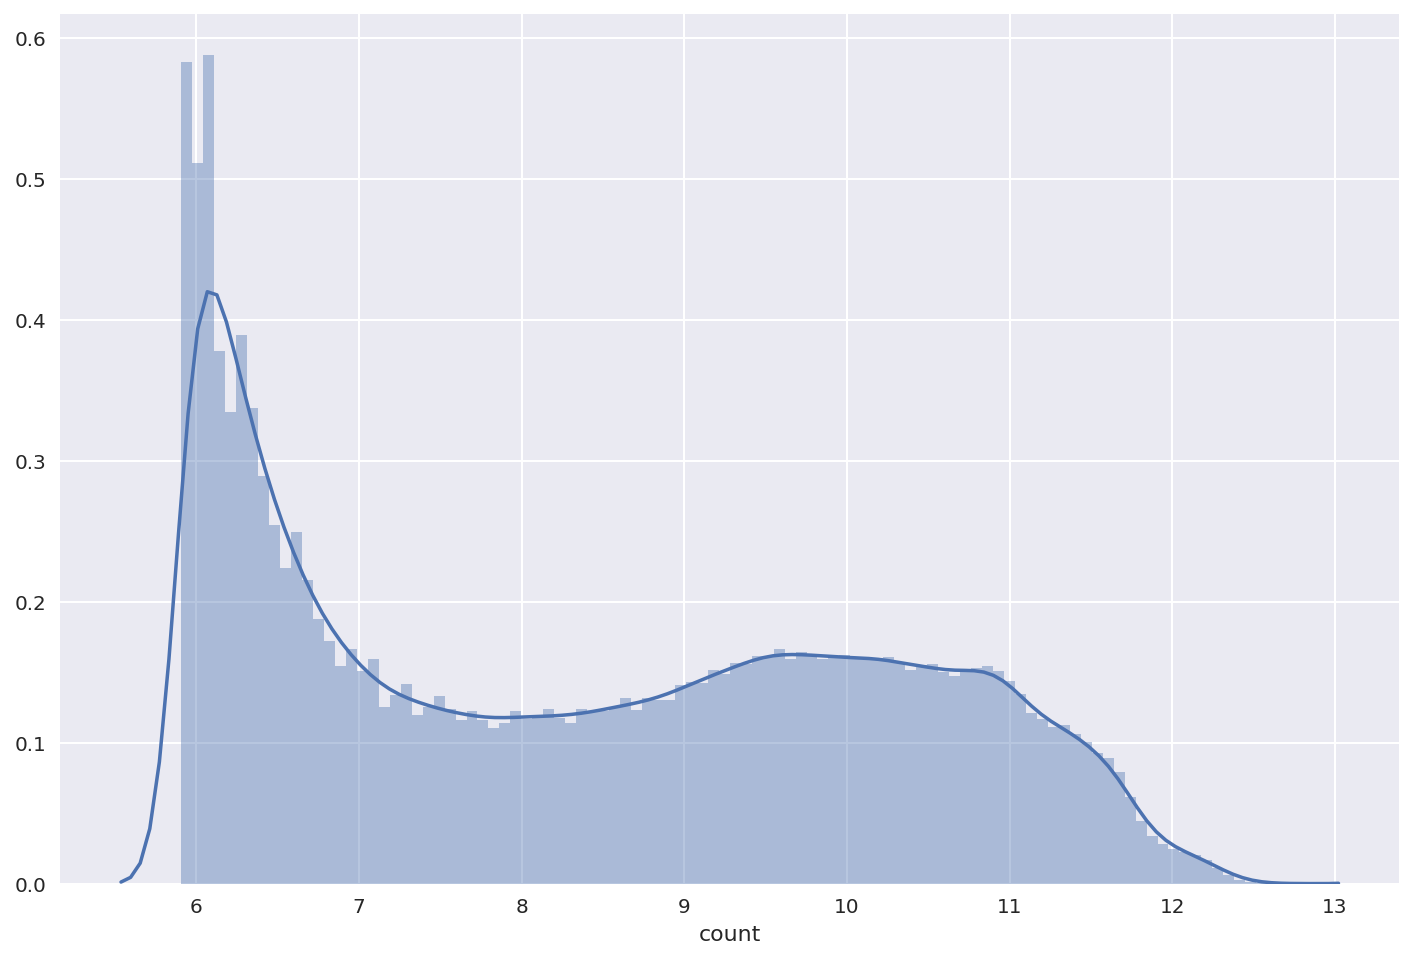

In [17]:
sns.distplot(np.log2(graph['count']), bins=100);

In [18]:
graph['src'] = graph['src'].apply(lambda x: keyinfo[x].split('.')[1])
graph['dest'] = graph['dest'].apply(lambda x: keyinfo[x].split('.')[1])

In [19]:
true_positive = graph[(graph['src']!='-1') & (graph['src']==graph['dest'])]
false_positive = graph[(graph['src']!='-1') & (graph['dest']!='-1') & (graph['src']!=graph['dest'])]

In [22]:
graph.shape,true_positive.shape,false_positive.shape

((1000000, 3), (366382, 3), (11528, 3))

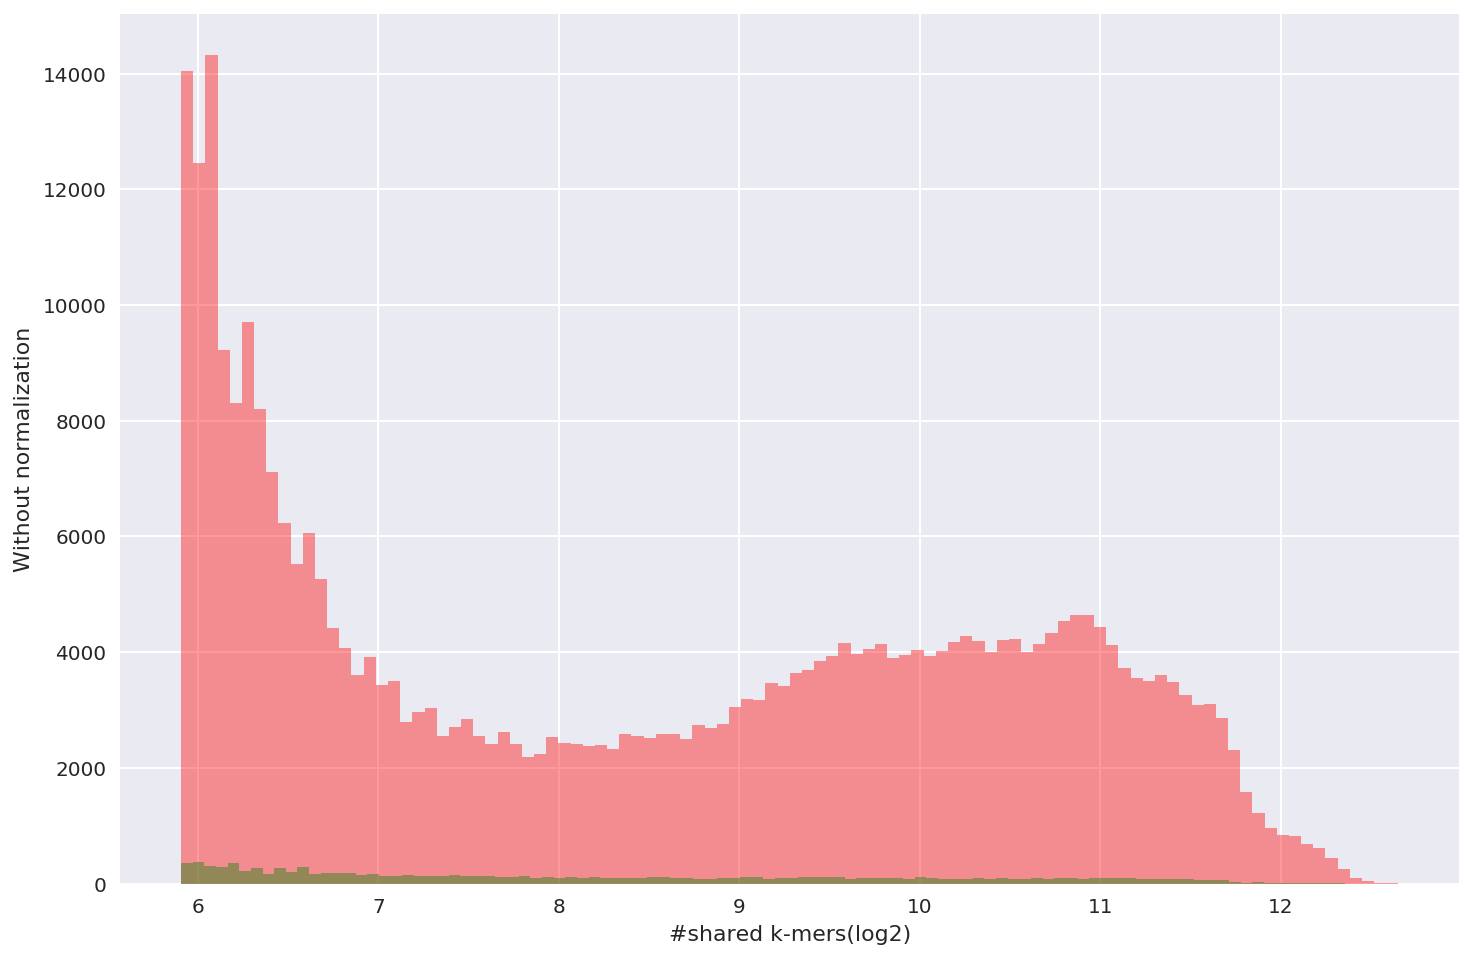

In [20]:
# no normalization
fig, ax = plt.subplots()
sns.distplot(np.log2(true_positive['count']), bins=100, ax=ax, color='red', kde=False, norm_hist=False);
sns.distplot(np.log2(false_positive['count']), bins=100, ax=ax, color='green', kde=False, norm_hist=False);
ax.set_xlabel('#shared k-mers(log2)');
ax.set_ylabel('Without normalization');

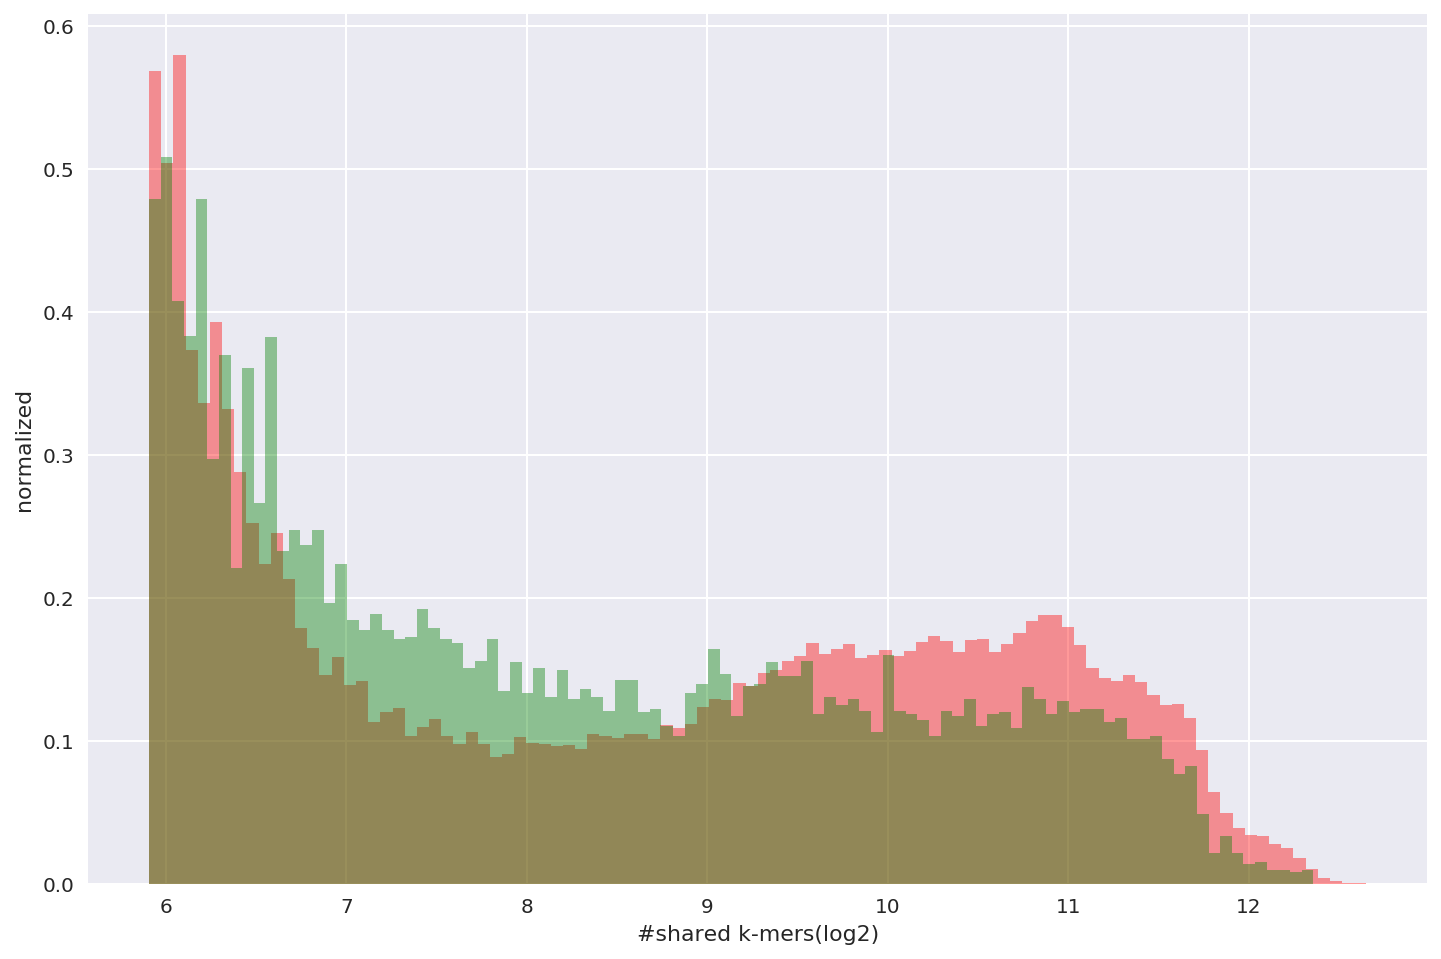

In [21]:
# with normalization
fig, ax = plt.subplots()
sns.distplot(np.log2(true_positive['count']), bins=100, ax=ax, color='red', norm_hist=True, kde=False);
sns.distplot(np.log2(false_positive['count']), bins=100, ax=ax, color='green', norm_hist=True, kde=False);
ax.set_xlabel('#shared k-mers(log2)');
ax.set_ylabel('normalized');